# Towards fairness in machine learning with adversarial networks 



## Introduction

From credit ratings to housing allocation, machine learning models are increasingly used to automate 'everyday' decision making processes. With the growing impact on society, more and more concerns are being voiced about the loss of transparency, accountability and fairness of the algorithms making the decisions. We as data scientists need to step-up our game and look for ways to mitigate emergent discrimination in our models. We need to make sure that our predictions do not disproportionately hurt people with certain sensitive characteristics (e.g., gender, ethnicity).

We will train a model for making income level predictions, analyse the fairness of its predictions and then show how adversarial training can be used to make it fair. The used approach is based on the 2017 NIPS paper ["Learning to Pivot with Adversarial Networks"](https://papers.nips.cc/paper/6699-learning-to-pivot-with-adversarial-networks) by Louppe et al. 

## Making income predictions

Let's start by training a basic classifier that can predict whether or not a person's income is larger than 50K dollar a year. Too make these income level predictions we turn to the [adult UCI](https://archive.ics.uci.edu/ml/datasets/Adult) dataset, which is also referred to as "Census Income" dataset. It is not hard to imagine that financial institutions train models on similar data sets and use them to decide whether or not someone is eligible for a loan, or to set the height of an insurance premium.

Before training a model, we first parse the data into three datasets: features, targets and sensitive attributes. The set of features $X$ contains the input attributes that the model uses for making the predictions, with attributes like age, education level and occupation. The targets $y$ contain the binary class labels that the model needs to predict.  These labels are $y\in\left\{income>50K, income\leq 50K\right\}$. Finally, the set of sensitive attributes $Z$ contains the attributes for which we want the prediction to fair. These are $z_{race}\in\left\{black, white\right\}$ and $z_{sex}\in\left\{male, female\right\}$. 

It is important to note that datasets are non-overlapping, so the sensitive attributes race and sex are **not** part of the features used for training the model.

In [1]:
# HIDE
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from IPython import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader



In [4]:
from fairness.helpers import load_ICU_data
from fairness.helpers import plot_distributions
#from fairness.helpers import plot_distributions2
from fairness.helpers import p_rule

torch.manual_seed(1)
np.random.seed(7)
sns.set_theme(style="white", palette="muted", color_codes=True, context="talk")

%matplotlib inline

## Data

Our goal is to predict income levels based on personal attributes, such as age, education and marital status.
The problem is that our standard classifier is unfair to black people and women.
All other attributes being equal, women will, for instance, have lower income predictions than men - even though gender is not part of the personal attributes.
Biases like this can be specific to a dataset or even reflect the real world, but we don't want them to lead to unfair predictions.

We will start with our dataset from the previous blog.
We have the following pandas DataFrames:

- `X_train`, `X_test`: attributes used for prediction - like age and native country
- `y_train`, `y_test`: target we want to predict - if someone makes more than 50K
- `Z_train`, `Z_test`: sensitive attributes - race and color

In [7]:
# load ICU data set
X, y, Z = load_ICU_data('ML_assignment/adult (1).data')

n_features = X.shape[1]
n_sensitive = Z.shape[1]

features X: 30940 samples, 93 attributes
targets y: (30940,) samples
sensitives Z: 30940 samples, 2 attributes


In [8]:
X

,age,education_num,capital_gain,capital_loss,hours_per_week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,country_Puerto-Rico,country_Scotland,country_South,country_Taiwan,country_Thailand,country_Trinadad&Tobago,country_United-States,country_Unknown,country_Vietnam,country_Yugoslavia
0,39,13,2174,0,40,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,50,13,0,0,13,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
2,38,9,0,0,40,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
3,53,7,0,0,40,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
4,28,13,0,0,40,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,12,0,0,38,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
32557,40,9,0,0,40,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
32558,58,9,0,0,40,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
32559,22,9,0,0,20,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False


In [9]:
Z

,race,sex
0,1,1
1,1,1
2,1,1
3,0,1
4,0,0
...,...,...
32556,1,0
32557,1,1
32558,1,0
32559,1,1


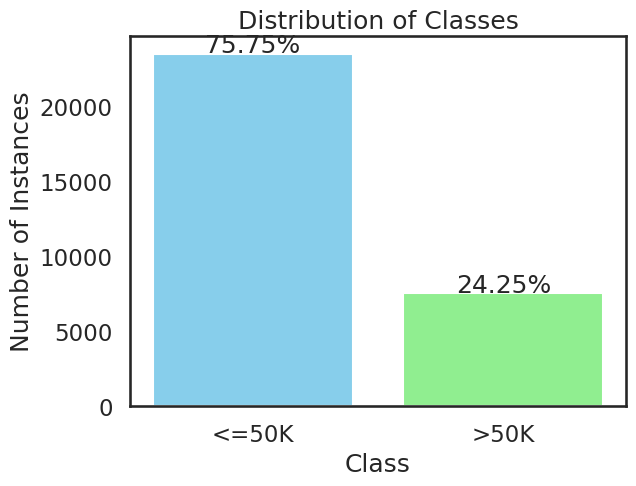

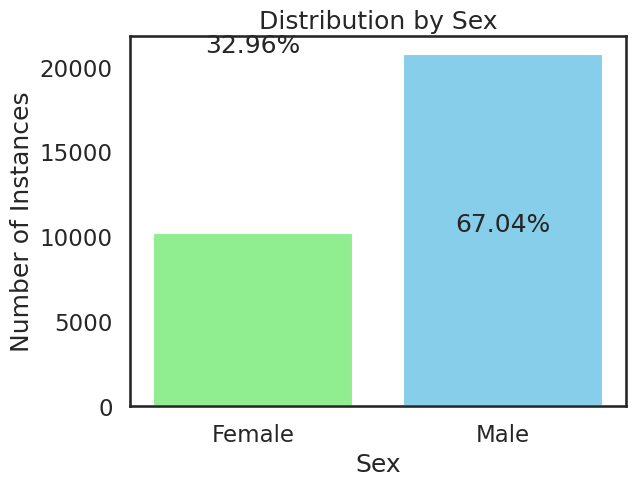

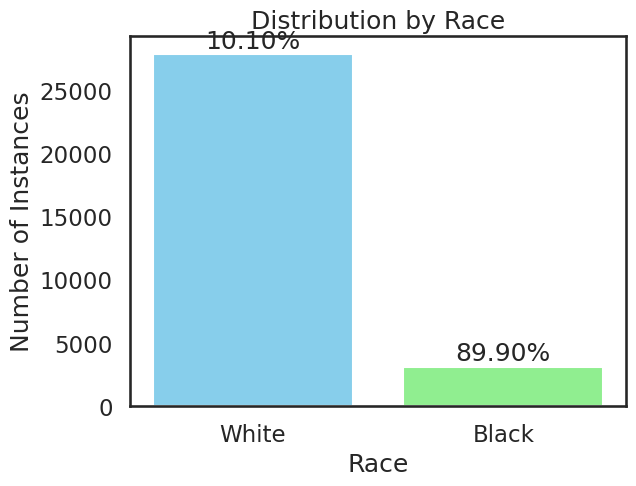

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Count the number of instances in each class
class_counts = pd.Series(y).value_counts()

# Calculate the proportions of each class relative to the total set
class_proportions = class_counts / len(y)

# Create the bar chart
fig, ax = plt.subplots()
colors = ['skyblue', 'lightgreen']
ax.bar(class_counts.index, class_counts, color=colors)

# Add the percentages of each class above the bars
for i, count in enumerate(class_counts):
    proportion = class_proportions[i]
    ax.text(i, count + 100, f'{proportion:.2%}', ha='center')

# Set the labels and title of the graph
ax.set_xticks(class_counts.index)
ax.set_xticklabels(['<=50K', '>50K'])
ax.set_ylabel('Number of Instances')
ax.set_xlabel('Class')
ax.set_title('Distribution of Classes')

# Show the graph
plt.show()

# Create a bar chart for the distribution by sex
sex_counts = pd.Series(Z['sex']).value_counts()
sex_proportions = sex_counts / len(Z['sex'])
fig, ax = plt.subplots()
ax.bar(sex_counts.index, sex_counts, color=colors)
for i, count in enumerate(sex_counts):
    proportion = sex_proportions[i]
    ax.text(i, count + 100, f'{proportion:.2%}', ha='center')
ax.set_xticks(sex_counts.index)
ax.set_xticklabels(['Male', 'Female'])
ax.set_ylabel('Number of Instances')
ax.set_xlabel('Sex')
ax.set_title('Distribution by Sex')
plt.show()

# Extract the race column from the dataset
race_values = Z['race']

# Count the number of instances in each race category
race_counts = pd.Series(race_values).value_counts()

# Calculate the proportions of each race category relative to the total set
race_proportions = race_counts / len(race_values)

# Create a bar chart for the distribution by race
race_counts = pd.Series(Z['race']).value_counts()
race_proportions = race_counts / len(Z['race'])
fig, ax = plt.subplots()
ax.bar(range(len(race_counts)), race_counts.values, color=colors)
for i, count in enumerate(race_counts):
    proportion = race_proportions[i]
    ax.text(i, count + 100, f'{proportion:.2%}', ha='center', va='bottom')
ax.set_xticks(range(len(race_counts)))
ax.set_xticklabels(['White', 'Black'])
ax.set_ylabel('Number of Instances')
ax.set_xlabel('Race')
ax.set_title('Distribution by Race')
plt.show()

Our dataset contains the information of just over 30K people. Next, we split the data into train and test sets, where the split is 50/50, and scale the features  𝑋  using standard scaling.

In [11]:
# split into train/test set
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, y, Z, test_size=0.5, 
                                                                     stratify=y, random_state=7)

# standardize the data
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler) 

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_performance(model, X_test, y_test):
    # Prediction on test data
    y_pred = model.predict(X_test)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculation of accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Display confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks([0, 1], ['Class 0', 'Class 1'])
    plt.yticks([0, 1], ['Class 0', 'Class 1'])
    plt.xlabel('Predicted class')
    plt.ylabel('Real class')

    # Display accuracy
    plt.text(0, -1.5, f'Accuracy: {accuracy*100:.2f}%', ha='left')
    
    # Display the number of instances and percentage in each part of the matrix
    total_instances = np.sum(cm)
    for i in range(2):
        for j in range(2):
            count = cm[i, j]
            percentage = count / total_instances * 100
            plt.text(j, i, f'{count}\n{percentage:.2f}%', ha='center', va='center',
                     color='white' if cm[i, j] > cm.max() / 2 else 'black')
    

    plt.show()


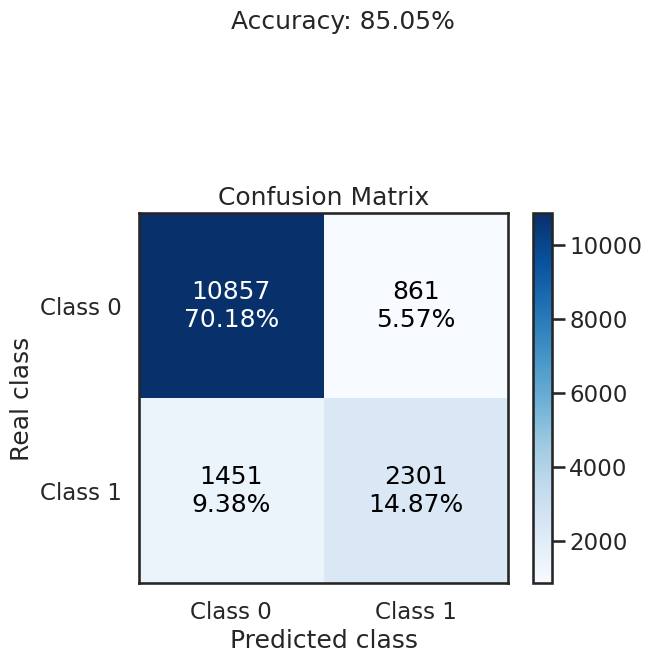

In [13]:
from sklearn.linear_model import LogisticRegressionCV
model=LogisticRegressionCV(cv=5).fit(X_train, y_train)
plot_performance(model,X_test,y_test)

## Using PyTorch

Now, let's train our basic income level predictor. 

PyTorch has some [tools](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#) to make data loading and sampling easier.
Here, we will use the `Dataset` and `DataLoader`.
A `Dataset` represents your dataset and returns samples from it.
The `DataLoader` takes a `Dataset` and helps you with shuffling and batching your samples.

A `Dataset` generally takes and returns PyTorch tensors, not rows from a pandas DataFrame.
Let's add some logic to the [`TensorDataset`](https://pytorch.org/docs/master/data.html#torch.utils.data.TensorDataset) that converts DataFrames into tensors.
Subclass the `TensorDataset` so we can initialize a `Dataset` with our pandas DataFrames:

In [14]:
class PandasDataSet(TensorDataset):

    def __init__(self, *dataframes):
        tensors = (self._df_to_tensor(df) for df in dataframes)
        super(PandasDataSet, self).__init__(*tensors)

    def _df_to_tensor(self, df):
        if isinstance(df, pd.Series):
            df = df.to_frame('dummy')
        return torch.from_numpy(df.values).float()


train_data = PandasDataSet(X_train, y_train, Z_train)
test_data = PandasDataSet(X_test, y_test, Z_test)

Create a `DataLoader` that returns shuffled batches of our training set:

In [15]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)

print('# training samples:', len(train_data))
print('# batches:', len(train_loader))

# training samples: 15470
# batches: 483


That is all the processing we need!
All the data needed for training and predicting are respectively in `train_loader` and `test_data`.
We get batches of data when iterating over the `train_loader`, `test_data` will be used to test our predictions.

## Income predictions

With our datasets in place, we define and pretrain the classifier to make income predictions.
This classifier will be good in predicting income level but is likely to be unfair - it is only penalized on performance and not on fairness.

The PyTorch's [`nn`](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#nn-module) module makes implementing a neural network easy.
We get a fully working network class by inheriting from `nn.Module` and implementing the `.forward()` method.
Our network consists of three sequential hidden layers with ReLu activation and dropout.
The sigmoid layer turns these activations into a probability for the income class.

In [16]:
class Classifier(nn.Module):

    def __init__(self, n_features, n_hidden=32, p_dropout=0.2):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, 1),
        )

    def forward(self, x):
        return torch.sigmoid(self.network(x))

Initialize the classifier, choose binary cross entropy as the loss function and let Adam optimize the weights of the classifier:

In [17]:
clf = Classifier(n_features=n_features)
clf_criterion = nn.BCELoss()
clf_optimizer = optim.Adam(clf.parameters())

Time to pretrain the classifier!
For each epoch, we'll iterate over the batches returned by our `DataLoader`.

In [18]:
# CHANGE

def pretrain_classifier(clf, data_loader, optimizer, criterion):
    for x, y, _ in data_loader:
        clf.zero_grad()
        p_y = clf(x)
        loss = criterion(p_y, y)
        loss.backward()
        optimizer.step()
    return clf

def evaluate_classifier(clf, test_data):
    clf.eval()  # Met le classifieur en mode évaluation (désactive le dropout)

    correct = 0
    total = 0

    with torch.no_grad():
        for x, y, _ in test_data:
            predictions = clf(x)
            predicted_labels = (predictions >= 0.5).float()  # Convertit les prédictions en étiquettes prédites (0 ou 1)

            correct += (predicted_labels == y).sum().item()
            total += y.size(0)

    accuracy = correct / total
    return accuracy


# CHANGE


N_CLF_EPOCHS = 2
for epoch in range(N_CLF_EPOCHS):
    clf = pretrain_classifier(clf, train_loader, clf_optimizer, clf_criterion)
    
# Évaluer l'exactitude du classifieur sur les données de test
test_accuracy = evaluate_classifier(clf, test_data)
print("Accuracy on test data:", test_accuracy)

Accuracy on test data: 0.8474466709760827


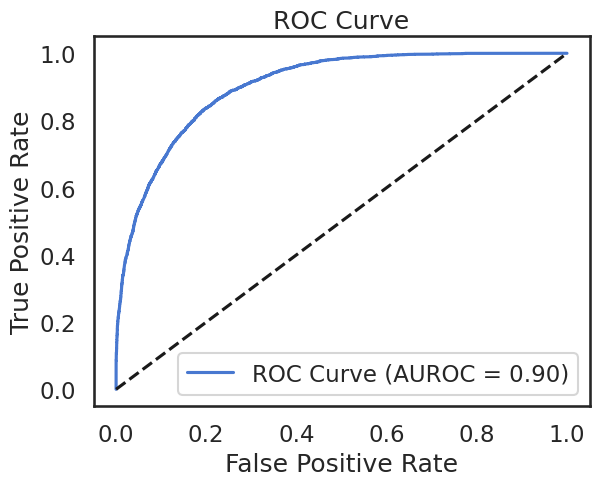

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve

# Predicting class labels with the classifier on the test data
y_pred = clf(test_data[:][0])

# Detaching the tensors from their computation history and converting them to NumPy arrays
y_test_np = test_data[:][1].detach().numpy()
y_pred_np = y_pred.detach().numpy()

# Calculating true positive rates and false positive rates
fpr, tpr, thresholds = roc_curve(y_test_np, y_pred_np)

# Calculating AUROC
auroc = roc_auc_score(y_test_np, y_pred_np)

# Displaying the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUROC = {:.2f})'.format(auroc))
plt.plot([0, 1], [0, 1], 'k--')  # Dashed line for random performance
plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

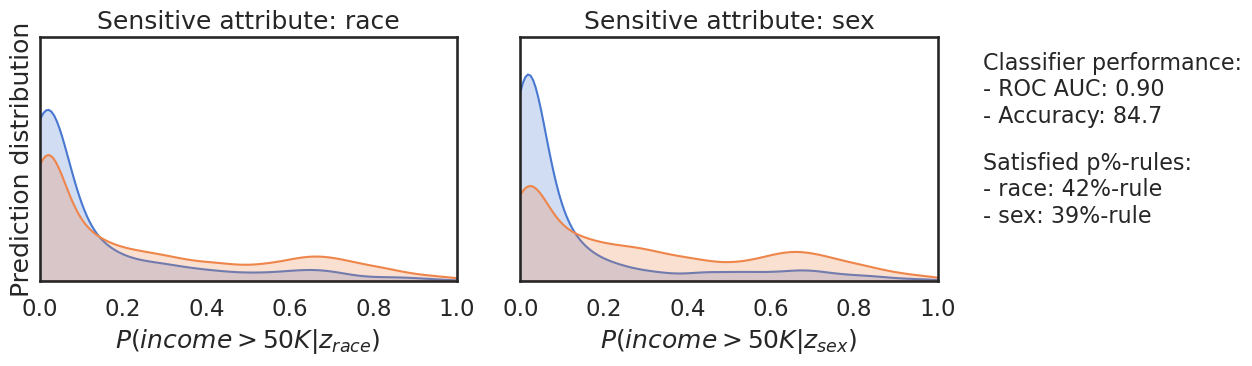

In [20]:
import warnings

with torch.no_grad():
    pre_clf_test = clf(test_data.tensors[0])

y_pre_clf = pd.Series(pre_clf_test.data.numpy().ravel(),
                      index=y_test.index)


with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    fig = plot_distributions(y_test, Z_test, y_pre_clf)

fig.savefig('torch_biased_training.png')

In [21]:
y_pre_clf

8573     0.682212
17445    0.041379
17338    0.390950
23146    0.001654
1763     0.003346
           ...   
13406    0.684801
29810    0.000118
3167     0.696561
2866     0.081035
16075    0.176653
Length: 15470, dtype: float32

In [22]:
Z_test

,race,sex
8573,1,1
17445,1,1
17338,1,1
23146,1,0
1763,0,1
...,...,...
13406,1,1
29810,1,1
3167,1,1
2866,1,1


The code above does the following for each batch:
- Set the gradients relevant to our classifier to zero.
- Let the classifier `clf` predict for a batch `x` to give `p_y`.
- Compute the loss given the predictions and the real answer.
- Backpropagate the loss with a  `.backward()` to give the gradients to decrease the errors.
- Let the classifier optimizer perform an optimization step with these gradients.

The result should be a fairly performant though still unfair classifier.
We will check the performance after defining the adversary.

## Detecting unfairness

With the classifier pretrained, we now define and pretrain the adversary.
Similar to the classifier, our adversary consists of three layers.
However, the input comes from a single class (the predicted income class) and the output consists of two sensitive classes (sex and race).

For our final solution, there will be a trade-off between classifier performance and fairness for our sensitive attributes.
We will tweak the adversarial loss to incorporate that trade-off: the lambda parameter weighs the adversarial loss of each class.
This parameter is later also used to scale the adversary performance versus the classifier performance.

By telling `nn.BCELoss` not to reduce we get the losses for each individual sample and class instead of a single number.
Multiplying this with our `lambdas` and taking the average, gives us the weighted adversarial loss, our proxy for unfairness.

In [23]:
# CHANGE

class Adversary(nn.Module):

    def __init__(self, n_sensitive, n_hidden=32):
        super(Adversary, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_sensitive),
        )

    def forward(self, x):
        return torch.sigmoid(self.network(x))


def pretrain_adversary(adv, clf, data_loader, optimizer, criterion):
    for x, _, z in data_loader:
        p_y = clf(x).detach()
        adv.zero_grad()
        p_z = adv(p_y)
        loss = (criterion(p_z, z) * lambdas).mean()
        loss.backward()
        optimizer.step()
    return adv


lambdas = torch.Tensor([130, 30])
adv = Adversary(Z_train.shape[1])
adv_criterion = nn.BCELoss(reduction='mean')
adv_optimizer = optim.Adam(adv.parameters())


N_ADV_EPOCHS = 5

for epoch in range(N_ADV_EPOCHS):
    adv=pretrain_adversary(adv, clf, train_loader, adv_optimizer, adv_criterion)

Training the adversary is pretty similar to how we trained the classifier.
Note that we [`.detach()`](https://pytorch.org/docs/master/autograd.html#torch.Tensor.detach) the predictions of the classifier from the graph.
This signals to PyTorch that we don't use the gradients of the classifier operations to optimize the adversary, allowing PyTorch to free up some memory.

Are our results similar to those of our earlier blog using keras and TensorFlow?
Pretty much!
The ROC AUC, accuracy and probability distributions look very similar.

In [24]:
with torch.no_grad():
    pre_adv_test = adv(pre_clf_test)

y_pre_adv = pd.DataFrame(pre_adv_test.numpy(), columns=Z.columns)

# Quantitative model fairness
In order to get a 'quantitative' measure of how fair our classifier is, we take inspiration from the U.S. Equal Employment Opportunity Commission (EEOC). They use the so-called 80% rule to quantify the disparate impact on a group of people of a protected characteristic. Zafar et al. show in their paper "Fairness Constraints: Mechanisms for Fair Classification" how a more generic version of this rule, called the p%-rule, can be used to quantify fairness of a classifier. This rule is defined as follows:

A classifier that makes a binary class prediction  𝑦̂ ∈{0,1}
  given a binary sensitive attribute  𝑧∈{0,1}
  satisfies the p%-rule if the following inequality holds:

min(𝑃(𝑦̂ =1|𝑧=1)𝑃(𝑦̂ =1|𝑧=0),𝑃(𝑦̂ =1|𝑧=0)𝑃(𝑦̂ =1|𝑧=1))≥𝑝100
 
The rule states that the ratio between the probability of a positive outcome given the sensitive attribute being true and the same probability given the sensitive attribute being false is no less than p:100. So, when a classifier is completely fair it will satisfy a 100%-rule. In contrast, when it is completely unfair it satisfies a %0-rule.

In determining the fairness our or classifier we will follow the EEOC and say that a model is fair when it satisfies at least an 80%-rule. So, let's compute the p%-rules for the classifier and put a number on its fairness. Note that we will threshold our classifier at 0.5 to make its prediction it binary.


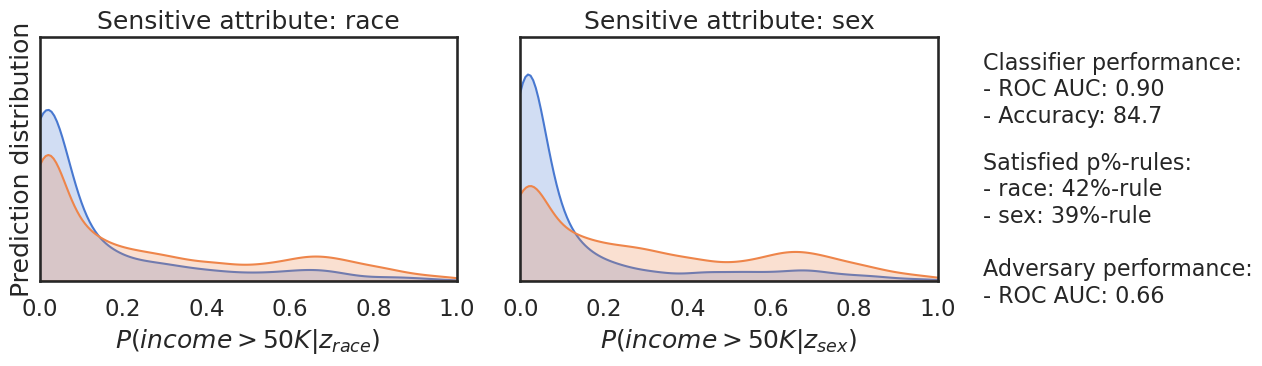

In [25]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    fig = plot_distributions(y_test, Z_test, y_pre_clf, y_pre_adv)  #y_pre_clf, y_pre_adv ne sont pas utilisés ils sont forcés à NONE dans plot_distributions2
fig.savefig('torch_biased_training.png')

Unfortunately, switching frameworks did not magically make the classifier fairer.
We can see this from the probability p%-rule and distributions, but also from the ROC AUC score of the adversary.
A score higher than 0.5 indicates that the adversary is able to detect unfairness.

## Training for fairness

Now that we have an unfair classifier and an adversary that is able to pick up on unfairness, we can engage them in the zero-sum game to make the classifier fair.
Remember that the fair classifier will be punished according to:

$$\min_{\theta_{clf}}\left[Loss_{y}(\theta_{clf})-\lambda Loss_{Z}(\theta_{clf},\theta_{adv})\right].$$

The first term represents how good the classifier is in predicting income, the second how good the adversary can reconstruct unfairness. 
The parameter $\lambda$ represents the trade-off between these terms: it weighs the punishment by the adversary versus the prediction performance.

The adversary learns on the full data set and the classifier is given only the single batch, giving the adversary a slight edge in learning.
The loss function for the classifier is changed to its original loss plus the weighted negative adversarial loss.

In [26]:
# HIDE
!rm -f fairness-in-ml/output/torch_*.png

In [29]:
import os

In [30]:
output_dir = 'fairness-in-ml/output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


In [31]:
plt.savefig(f'{output_dir}/torch_{epoch+1:08d}.png', bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

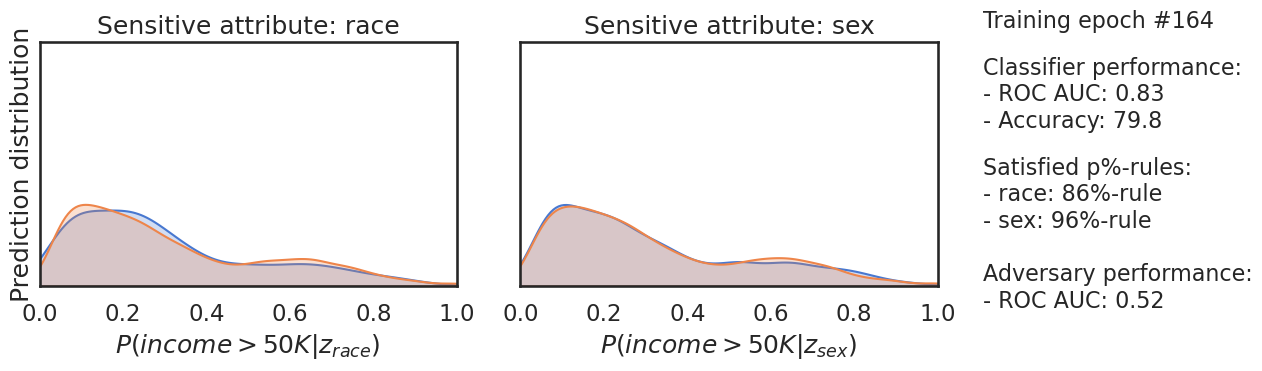

In [32]:
import os

# Train classifier and adversary
def train(clf, adv, data_loader, clf_criterion, adv_criterion,
          clf_optimizer, adv_optimizer, lambdas):
    
    # Train adversary
    for x, y, z in data_loader:
        adv.zero_grad()
        p_y = clf(x)
        p_z = adv(p_y)
        loss_adv = (adv_criterion(p_z, z) * lambdas).mean()
        loss_adv.backward()
        adv_optimizer.step()
 
    # Train classifier on single batch
    for x, y, z in data_loader:
        pass
    clf.zero_grad()
    p_y = clf(x)
    p_z = adv(p_y)
    clf_loss = clf_criterion(p_y, y) - (adv_criterion(p_z, z) * lambdas).mean()
    clf_loss.backward()
    clf_optimizer.step()
    
    return clf, adv

N_EPOCH_COMBINED = 165
output_dir = 'fairness-in-ml/output'

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for epoch in range(1, N_EPOCH_COMBINED):
    
    clf, adv = train(clf, adv, train_loader, clf_criterion, adv_criterion,
                     clf_optimizer, adv_optimizer, lambdas)

    with torch.no_grad():
        clf_pred = clf(test_data.tensors[0])
        adv_pred = adv(clf_pred)

    y_post_clf = pd.Series(clf_pred.numpy().ravel(), index=y_test.index)
    Z_post_adv = pd.DataFrame(adv_pred.numpy(), columns=Z_test.columns)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        fig = plot_distributions(y_test, Z_test, y_post_clf, Z_post_adv, epoch)
    
    display.clear_output(wait=True)
    
    # Save figure
    plt.savefig(f'{output_dir}/torch_{epoch+1:08d}.png', bbox_inches='tight')
    plt.show(plt.gcf())

last_img = f'{output_dir}/torch_{epoch+1:08d}.png'


In [33]:
from PIL import Image
import glob

# Chemin vers les images d'entrée
input_path = 'fairness-in-ml/output/torch_*.png'

# Charger les images dans une liste
images = []
for file in sorted(glob.glob(input_path)):
    images.append(Image.open(file))

# Chemin et nom de fichier de la sortie GIF
output_gif = 'fairness-in-ml/images/torch_training.gif'

# Créer l'animation GIF avec une durée de 100 ms entre chaque image
images[0].save(output_gif, save_all=True, append_images=images[1:], optimize=False, loop=0, duration=100)


FileNotFoundError: [Errno 2] No such file or directory: 'fairness-in-ml/images/torch_training.gif'

In [ ]:
# HIDE
!convert -loop 0 -delay 0 fairness-in-ml/output/torch_*.png -delay 500 {last_img} fairness-in-ml/images/torch_training.gif

The classifier starts off unfair, but trades some of its performance for fairness.
At the end of training, the ROC AUC of the adversary is 0.50, indicating that it's unable to detect race or gender from the made predictions.
That's also shown by the p-rules: they're both above 80%.
We've successfully used an adversarial neural network to make our classifier fair!